# Best practice for plotting batch-runs

In [13]:
import os
import bokeh
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cellpy import cellreader
from cellpy.utils import ica
from cellpy.exceptions import NullData
import holoviews as hv
import altair as alt
%matplotlib inline

### Setting file names and loading data

In [2]:
my_data = cellreader.CellpyData()
filename = "../testdata/hdf5/20160805_test001_45_cc.h5"
assert os.path.isfile(filename)

In [3]:
my_data.load(filename)
my_data.set_mass(0.1)

### Checking the data

#### voltage cycles

In [4]:
capacity, voltage = my_data.get_cap()

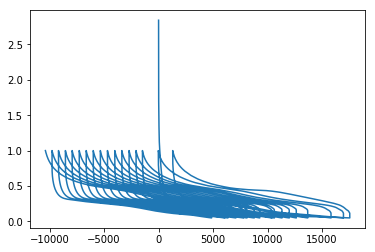

In [5]:
plt.plot(capacity, voltage)

In [6]:
cycles = my_data.get_cycle_numbers()

In [14]:
charge_cycles = list()
for c in cycles:
    try:
        ccv = my_data.get_ccap(c)
        charge_cycles.append(ccv)
    except NullData:
        print(f"Cycle {c}: no data")
        
charge_cycles = np.array(charge_cycles)

Cycle 18: no data


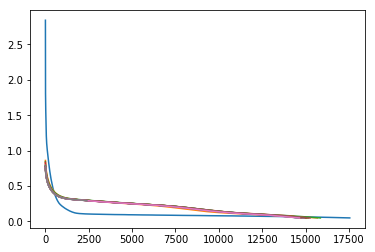

In [15]:
for x,y in discharge_cycles:
    plt.plot(x,y)

In [43]:
def make_charge_list(data):
    """Create a list of pandas.DataFrames, one for each charge step.
    
    The DataFrames are named by its cycle number.
    
    Input: CellpyData
    Returns: list of pandas.DataFrames
        minimum voltage value,
        maximum voltage value"""
    
    minimum_v_value = np.Inf
    maximum_v_value = -np.Inf
    charge_list = []
    cycles = my_data.get_cycle_numbers()
    for cycle in cycles:
        try:
            q, v = data.get_ccap(cycle)
        except NullData as e:
            print(e)
            break
        else:
            d = pd.DataFrame({"q": q, "v": v})
            #d.name = f"{cycle}"
            d.name = cycle
            charge_list.append(d)
            v_min = v.min()
            v_max = v.max()
            if v_min < minimum_v_value:
                minimum_v_value = v_min
            if v_max > maximum_v_value:
                maximum_v_value = v_max
    return charge_list, minimum_v_value, maximum_v_value


In [44]:
charge_dfs, minimum_v, maximum_v = make_charge_list(my_data)

no steps found (c:18 s:0 type:charge)


In [45]:
charge_df = pd.concat(charge_dfs, axis=1, keys=[k.name for k in charge_dfs])

In [63]:
charge_df.head(3)

1             2       3       4       5      ...  13      \
                    q         v   q   v   q   v   q   v   q   v ...   q   v   
Data_Point                                                      ...           
1068         0.000030  0.110245 NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
1069         2.787906  0.115479 NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
1070        14.254993  0.120714 NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   

            14      15      16      17      
             q   v   q   v   q   v   q   v  
Data_Point                                  
1068       NaN NaN NaN NaN NaN NaN NaN NaN  
1069       NaN NaN NaN NaN NaN NaN NaN NaN  
1070       NaN NaN NaN NaN NaN NaN NaN NaN  

[3 rows x 34 columns]

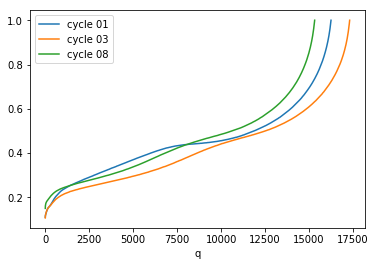

In [59]:
n1, n2, n3 = (1, 3, 8)
ax = charge_df[n1].plot(x="q", y="v", label=f"cycle {str(n1).zfill(2)}")
charge_df[n2].plot(x="q", y="v", ax=ax, label=f"cycle {str(n2).zfill(2)}")
charge_df[n3].plot(x="q", y="v", ax=ax, label=f"cycle {str(n3).zfill(2)}")

### Checking ica

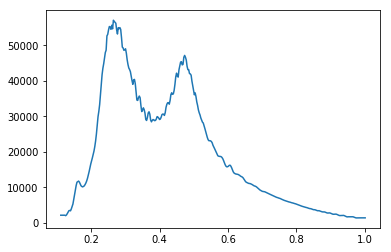

In [32]:
c, v = charge_cycles[2]
dq, dv = ica.dqdv(v, c)
plt.plot(dq,dv)

In [33]:
print(f"min, max = ({minimum_v} {maximum_v})")

min, max = (0.107165687 1.00011349)


## Creating dqdv-data

In [64]:
def custom_dq_dv(capacity, voltage, minimum_v, maximum_v):
    converter = ica.Converter()
    converter.set_data(capacity, voltage)
    converter.inspect_data()
    converter.pre_process_data()
    converter.increment_data()
    converter.fixed_voltage_range = [minimum_v, maximum_v, 100]
    converter.post_process_data()
    return converter.voltage_processed, converter.incremental_capacity

In [65]:
incremental_charge_list = []
for (cap, volt), cycle in zip(charge_cycles, cycles):
    if cap.any():
        dv, dq = custom_dq_dv(cap, volt, minimum_v, maximum_v)
        if not incremental_charge_list:
            d = pd.DataFrame({"dv": dv})
            d.name = "voltage"
            incremental_charge_list.append(d)

            d = pd.DataFrame({f"dq": dq})
            d.name = cycle
            incremental_charge_list.append(d)
            
        else:
            d = pd.DataFrame({f"dq": dq})
            #d.name = f"{cycle}"
            d.name = cycle
            incremental_charge_list.append(d)
    else:
        print(f"{cycle} is empty")

In [66]:
ica_df = pd.concat(incremental_charge_list, axis=1, keys=[k.name for k in incremental_charge_list])

In [67]:
ica_df.columns.names = ["cycle", "value"]

In [68]:
ica_df.head(12)

cycle,voltage,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
value,dv,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq
0,0.107166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.116185,2519.950322,2363.935462,2156.213995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.125205,2477.984602,2256.832187,2048.303451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.134225,3572.263901,3467.901396,3291.390325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.143244,4604.181277,4555.014823,4263.244182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2273.385348,NaN,NaN,2307.505841,NaN
5,0.152264,7464.036796,8334.121117,8281.784400,2370.476832,NaN,NaN,NaN,NaN,2561.918647,NaN,NaN,NaN,2273.385348,2443.943193,2360.414896,2306.056451,2467.868467
6,0.161284,10068.675595,11869.378576,11613.166190,2370.476832,2583.295406,2561.959369,2651.352245,2517.566065,2561.918647,2669.098195,2586.942792,2473.933268,2273.385348,2438.421192,2360.414896,2564.001490,2467.868467
7,0.170303,8462.445570,10361.889972,10488.188951,2621.092237,2583.295406,2561.959369,2647.311942,2517.566065,3276.092472,2669.098195,2552.495245,2380.110401,3467.982396,3335.892601,2815.947936,5415.527174,2294.713733
8,0.179323,7263.126501,10110.189686,10363.776171,6018.696706,2904.659547,3170.052025,3032.527754,3022.877771,6462.938107,2936.677608,4214.827540,4214.871715,6632.469311,6487.326379,6047.439535,10091.735340,4765.085479


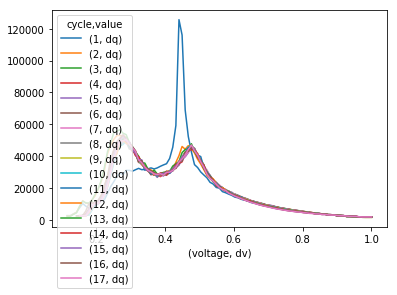

In [69]:
ica_df.plot(x=("voltage","dv"))

**Success!**

In [70]:
ica_df.head()

cycle,voltage,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
value,dv,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq
0,0.107166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.116185,2519.950322,2363.935462,2156.213995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.125205,2477.984602,2256.832187,2048.303451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.134225,3572.263901,3467.901396,3291.390325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.143244,4604.181277,4555.014823,4263.244182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2273.385348,NaN,NaN,2307.505841,NaN


In [71]:
ica_long_multiindex = ica_df.copy()

In [72]:
ica_long_multiindex.head()

cycle,voltage,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
value,dv,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq
0,0.107166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.116185,2519.950322,2363.935462,2156.213995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.125205,2477.984602,2256.832187,2048.303451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.134225,3572.263901,3467.901396,3291.390325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.143244,4604.181277,4555.014823,4263.244182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2273.385348,NaN,NaN,2307.505841,NaN


In [73]:
long_multiindex = ica_long_multiindex.melt("voltage", var_name="cycle", value_name="dq", col_level=0)

In [74]:
long_multiindex.head()

,voltage,cycle,dq
0,0.107166,1,NaN
1,0.116185,1,2519.950322
2,0.125205,1,2477.984602
3,0.134225,1,3572.263901
4,0.143244,1,4604.181277


In [75]:
long_multiindex.tail()

,voltage,cycle,dq
1695,0.964035,17,1790.955770
1696,0.973054,17,1682.806031
1697,0.982074,17,1686.755631
1698,0.991094,17,1686.755631
1699,1.000113,17,1686.755631


### Plotting with Altair

In [76]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

|   Data Type    |    Shorthand Code   |   Description                     |
|----------------|---------------------|-----------------------------------|
| quantitative   | Q                   | a continuous real-valued quantity |
|ordinal | O | a discrete ordered quantity|
|nominal | N | a discrete unordered category|
|temporal | T | a time or date value|

In [77]:
alt.Chart(long_multiindex).mark_line().encode(
  x='voltage:Q',
  y='dq:Q',
  color='cycle:O'
).interactive()

TypeError: Object of type 'int64' is not JSON serializable

In [78]:
import altair as alt
from vega_datasets import data

stocks = long_multiindex

highlight = alt.selection(type='single', on='mouseover',
                          fields=['cycle'], nearest=True)

base = alt.Chart(stocks).encode(
    x='voltage:Q',
    y='dq:Q',
    color='cycle:O'
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=600
)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(3))
).interactive()

points + lines

TypeError: Object of type 'int64' is not JSON serializable

Easy...but a bit limiting?

### Trying Bokeh

The main benifit with using Bokeh: interactive html

In [79]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [80]:
# trick to flatten the multiindex (not sure if HoloViews takes multiindex)
# ica_df.columns = ['_'.join(col).strip() for col in ica_df.columns.values]

In [81]:
from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid
from bokeh.plotting import figure, show
from bokeh.palettes import Spectral11, Paired, Viridis256
from bokeh.models.glyphs import MultiLine, Line
from bokeh.io import show
import itertools
from bokeh.transform import linear_cmap

In [82]:
# source = ColumnDataSource(ica_df) # bokeh automatically flattens multiindexed columns using "_".join(k) (i.e. must be str)
# source.data

In [83]:
source = ColumnDataSource(long_multiindex)

In [84]:
xrange = DataRange1d()
yrange = DataRange1d()
plot = figure(x_range=xrange, y_range=yrange, plot_width=800, plot_height=300)
plot.line(source=source, x="voltage", y="dq", legend="cycle") #, line_color=linear_cmap('cycle', "Viridis256", 0, 255))
show(plot)
# How can I set a color palette? mappers?

Not sure if I want to do this anymore. Bokeh is a little bit of a "luremus"..
Lets check if Holoviews makes life a little bit easier.

### Plotting with HoloViews

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
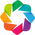

In [85]:
hv.extension('bokeh')

In [86]:
curve = hv.Curve(long_multiindex, kdims=['voltage', "dq"], vdims=['cycle'])
curve

:Curve   [voltage,dq]   (cycle)

In [89]:

curve2 = hv.Curve(long_multiindex, kdims=["voltage", "dq"], vdims="cycle")
curve2

:Curve   [voltage,dq]   (cycle)

In [90]:
long_multiindex.head()

,voltage,cycle,dq
0,0.107166,1,NaN
1,0.116185,1,2519.950322
2,0.125205,1,2477.984602
3,0.134225,1,3572.263901
4,0.143244,1,4604.181277


In [91]:
from bokeh.sampledata.iris import flowers
from holoviews.operation import gridmatrix

iris_ds = hv.Dataset(flowers)

In [92]:
%%opts Bivariate [bandwidth=0.5] (cmap='Blues') Points [tools=['box_select']] (size=2)
density_grid = gridmatrix(iris_ds, diagonal_type=hv.Distribution, chart_type=hv.Bivariate)
point_grid = gridmatrix(iris_ds, chart_type=hv.Points)

density_grid * point_grid

:GridMatrix   [X,Y]
   :Overlay
      .Distribution.I :Distribution   [sepal_width]   (Density)
      .Histogram.I    :Histogram   [sepal_width]   (sepal_width_frequency)